In [1]:
import sys
sys.path.append("Read_NM_CoulombIntegral/build")

import Reader as rd
import numpy as np
import matplotlib.pyplot as plt
from ipyparallel import Client
from operator import concat
from functools import reduce
import h5py as h5


%matplotlib inline

In [67]:
alphai = 850

f = h5.File("Levy.h5", "r")

alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)

alphas[alphai]

1.7754254254254254

In [203]:
def integrate(params):
    d = "/gpfs/mnt/gpfs02/phenix/plhf/plhf1/abagoly/workdir/HBTCoulombCorrection"
    import sys
    sys.path.append(d)
    import KGInt as kg
    import numpy as np
    import h5py as h5
    
    f = h5.File(d+"/Levy.h5", "r")

    alphai = 850

    limits = f["limits"][str(alphai)].value
    alphas = np.linspace(f["alphas"]["min_alpha"].value,f["alphas"]["max_alpha"].value, f["alphas"]["length"].value)
    dr     = f["dr"][str(alphai)].value
    
    l=kg.Levyd(1., alphas[alphai], limits[0], limits[1], dr, f["Lr"][str(alphai)].value, 1e-8)
    c = kg.Coulomb2d(l)
        
    res = []
    for par in params:
        c.set_R(par[1])
        res.append(c.integrate(par[0],int(1e7)))
    return res

In [211]:
r = rd.Reader()

In [204]:
client = Client(profile="condor2", timeout=300)
dv = client[:]
len(client.ids)

36

In [218]:
N       = 36*10
workers = len(client.ids)

if np.ceil(N/workers)!=np.floor(N/workers):
    print("number of nodes not compatible with the workers")

ks = np.linspace(2,40, N)

In [219]:
R = 3
alpha = alphas[alphai]

In [220]:
data = list(zip(*[iter(list(zip(ks, [R*2**(1./alpha)]*len(ks))))]*int(N/workers)))

In [221]:
res = dv.map_async(integrate, data)

In [222]:
res.wait_interactive()

  36/36 tasks finished after  193 s
done


In [223]:
my = reduce(concat, res.get())

In [240]:
cc = []
kcc = np.linspace(2, ks[-1],1000)
for k in kcc:
    cc.append(r.get(1,alpha=alpha, R=R*2**(-1/alpha), k=2*k))
cc=np.array(cc)

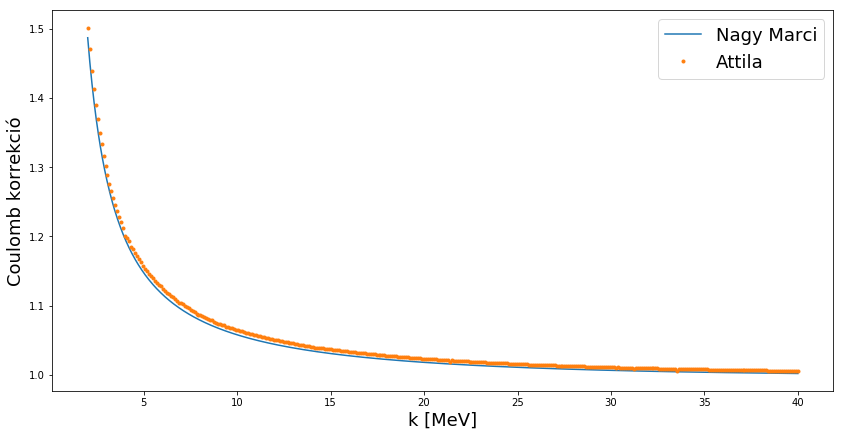

In [241]:
plt.figure(0,(14,7))
plt.xlabel("k [MeV]", fontsize=18)
plt.ylabel("Coulomb korrekció", fontsize=18)
plt.plot(kcc, 1/cc, label="Nagy Marci")
plt.plot(ks, my,'.', label="Attila")
plt.legend(fontsize=18)

In [242]:
cc = []
for k in ks:
    cc.append(r.get(1,alpha=alpha, R=R*2**(-1/alpha), k=2*k))
cc=np.array(cc)

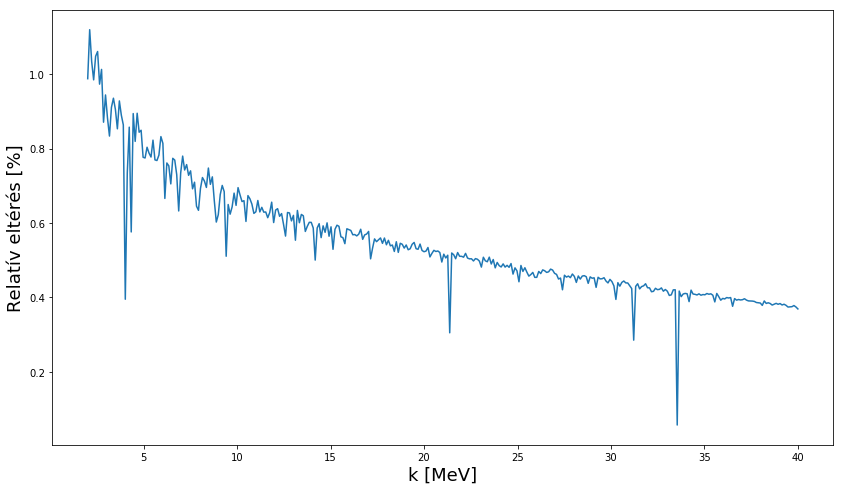

In [243]:
plt.figure(0,(14,8))
plt.xlabel("k [MeV]", fontsize=18)
plt.ylabel("Relatív eltérés [%]", fontsize=18)
plt.plot(ks, 100* (cc*abs(1/cc-my)))